In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
import pandas as pd

In [2]:
from torch.utils.data.dataset import Dataset


label_idx = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}


class IrisDataset(Dataset):

    def __init__(self, data):
        self.data = data
           
    def __getitem__(self, index):
        item = self.data.iloc[index].values
        return (item[0:4].astype(np.float32), item[4].astype(np.int))

    def __len__(self):
        return self.data.shape[0]


def get_datasets(iris_file, train_ratio=0.80):

    labels = {'class': label_idx}
    data = pd.read_csv(iris_file)
    data.replace(labels, inplace=True)

    train_df = data.sample(frac=train_ratio, random_state=3)
    test_df = data.loc[~data.index.isin(train_df.index), :]

    return IrisDataset(train_df), IrisDataset(test_df)

In [3]:
!head data/iris.data.txt

sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa


### Fully Connected Feed Fwd Net

In [4]:
class IrisNet(nn.Module):
    
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [5]:
model = IrisNet(4, 100, 50, 3).cuda()
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


### Creating the data loader

In [6]:
batch_size = 60
iris_data_file = 'data/iris.data.txt'

In [7]:
# Get the datasets
train_ds, test_ds = get_datasets(iris_data_file)

print("training set length", len(train_ds))
print("test set length", len(test_ds))

train_loader = torch.utils.data.DataLoader(dataset = train_ds, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_ds, batch_size = batch_size, shuffle = True)

training set length 120
test set length 30


In [8]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, nesterov=True, momentum=0.9, dampening=0)

## Training Loop

In [9]:
# 2 loops outer loop executes the epochs. Inner loop executes the iterations per epoch.
num_epochs = 500
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    for i, (items, classes) in enumerate(train_loader):
        # Each batch is a tuple. First element is a float tensor containing all the dependent variables for each batch
        # Second element of tuple
        # Convert torch tensor to variable
        items = Variable(items.cuda())
        classes = Variable(classes.cuda())
        model.train()
        # Clear off gradients from past operations
        optimizer.zero_grad()
        # Do the forward pass
        outputs = model(items)
        # Calculate the loss
        loss = criterion(outputs, classes)
        # Calculate the gradients with the help of back propagation
        loss.backward()
        # Ask the opitmizer to update the parameters on the basis of the gradients
        optimizer.step()
        
        # Record the correct predictions for training data
        train_total += classes.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == classes.data).sum()
        print('Epoch %d/%d, Iteration %d/%d, Loss: %.4f'%(epoch+1, num_epochs, i+1, len(train_ds)//batch_size, loss.data[0]))
    
    model.eval()
    train_loss.append(loss.data[0])
    
    #Record the training accuracy
    train_accuracy.append(100*train_correct/train_total)
    
    #Check on the test set
    test_items = torch.FloatTensor(test_ds.data.values[:,0:4])
    test_classes = torch.LongTensor(test_ds.data.values[:,4])
    outputs = model(Variable(test_items.cuda()))
    loss = criterion(outputs, Variable(test_classes.cuda()))
    test_loss.append(loss.data[0])
    
    #Record the testing accuracy
    _, predicted = torch.max(outputs.data,1)
    total = test_classes.size(0)
    correct = (predicted==test_classes.cuda()).sum()
    test_accuracy.append((100*correct/total))

Epoch 1/500, Iteration 1/2, Loss: 1.2179
Epoch 1/500, Iteration 2/2, Loss: 1.1851
Epoch 2/500, Iteration 1/2, Loss: 1.1945
Epoch 2/500, Iteration 2/2, Loss: 1.1788
Epoch 3/500, Iteration 1/2, Loss: 1.1689
Epoch 3/500, Iteration 2/2, Loss: 1.1642
Epoch 4/500, Iteration 1/2, Loss: 1.1034
Epoch 4/500, Iteration 2/2, Loss: 1.1852
Epoch 5/500, Iteration 1/2, Loss: 1.1254
Epoch 5/500, Iteration 2/2, Loss: 1.1222
Epoch 6/500, Iteration 1/2, Loss: 1.1056
Epoch 6/500, Iteration 2/2, Loss: 1.1055
Epoch 7/500, Iteration 1/2, Loss: 1.0860
Epoch 7/500, Iteration 2/2, Loss: 1.0937
Epoch 8/500, Iteration 1/2, Loss: 1.0734
Epoch 8/500, Iteration 2/2, Loss: 1.0751
Epoch 9/500, Iteration 1/2, Loss: 1.0776
Epoch 9/500, Iteration 2/2, Loss: 1.0461
Epoch 10/500, Iteration 1/2, Loss: 1.0585
Epoch 10/500, Iteration 2/2, Loss: 1.0380
Epoch 11/500, Iteration 1/2, Loss: 1.0604
Epoch 11/500, Iteration 2/2, Loss: 1.0170
Epoch 12/500, Iteration 1/2, Loss: 1.0336
Epoch 12/500, Iteration 2/2, Loss: 1.0262
Epoch 13/5

Epoch 104/500, Iteration 1/2, Loss: 0.3963
Epoch 104/500, Iteration 2/2, Loss: 0.4105
Epoch 105/500, Iteration 1/2, Loss: 0.4211
Epoch 105/500, Iteration 2/2, Loss: 0.3806
Epoch 106/500, Iteration 1/2, Loss: 0.3836
Epoch 106/500, Iteration 2/2, Loss: 0.4122
Epoch 107/500, Iteration 1/2, Loss: 0.3981
Epoch 107/500, Iteration 2/2, Loss: 0.3916
Epoch 108/500, Iteration 1/2, Loss: 0.3540
Epoch 108/500, Iteration 2/2, Loss: 0.4295
Epoch 109/500, Iteration 1/2, Loss: 0.4335
Epoch 109/500, Iteration 2/2, Loss: 0.3443
Epoch 110/500, Iteration 1/2, Loss: 0.3908
Epoch 110/500, Iteration 2/2, Loss: 0.3820
Epoch 111/500, Iteration 1/2, Loss: 0.3737
Epoch 111/500, Iteration 2/2, Loss: 0.3939
Epoch 112/500, Iteration 1/2, Loss: 0.3562
Epoch 112/500, Iteration 2/2, Loss: 0.4062
Epoch 113/500, Iteration 1/2, Loss: 0.3452
Epoch 113/500, Iteration 2/2, Loss: 0.4127
Epoch 114/500, Iteration 1/2, Loss: 0.3923
Epoch 114/500, Iteration 2/2, Loss: 0.3607
Epoch 115/500, Iteration 1/2, Loss: 0.3631
Epoch 115/5

Epoch 207/500, Iteration 1/2, Loss: 0.1967
Epoch 207/500, Iteration 2/2, Loss: 0.2192
Epoch 208/500, Iteration 1/2, Loss: 0.2192
Epoch 208/500, Iteration 2/2, Loss: 0.1946
Epoch 209/500, Iteration 1/2, Loss: 0.1921
Epoch 209/500, Iteration 2/2, Loss: 0.2195
Epoch 210/500, Iteration 1/2, Loss: 0.2159
Epoch 210/500, Iteration 2/2, Loss: 0.1928
Epoch 211/500, Iteration 1/2, Loss: 0.1888
Epoch 211/500, Iteration 2/2, Loss: 0.2183
Epoch 212/500, Iteration 1/2, Loss: 0.2211
Epoch 212/500, Iteration 2/2, Loss: 0.1832
Epoch 213/500, Iteration 1/2, Loss: 0.2100
Epoch 213/500, Iteration 2/2, Loss: 0.1937
Epoch 214/500, Iteration 1/2, Loss: 0.2144
Epoch 214/500, Iteration 2/2, Loss: 0.1859
Epoch 215/500, Iteration 1/2, Loss: 0.1893
Epoch 215/500, Iteration 2/2, Loss: 0.2085
Epoch 216/500, Iteration 1/2, Loss: 0.1766
Epoch 216/500, Iteration 2/2, Loss: 0.2194
Epoch 217/500, Iteration 1/2, Loss: 0.1738
Epoch 217/500, Iteration 2/2, Loss: 0.2199
Epoch 218/500, Iteration 1/2, Loss: 0.2053
Epoch 218/5

Epoch 310/500, Iteration 1/2, Loss: 0.1128
Epoch 310/500, Iteration 2/2, Loss: 0.1545
Epoch 311/500, Iteration 1/2, Loss: 0.1357
Epoch 311/500, Iteration 2/2, Loss: 0.1316
Epoch 312/500, Iteration 1/2, Loss: 0.1194
Epoch 312/500, Iteration 2/2, Loss: 0.1453
Epoch 313/500, Iteration 1/2, Loss: 0.1135
Epoch 313/500, Iteration 2/2, Loss: 0.1541
Epoch 314/500, Iteration 1/2, Loss: 0.1303
Epoch 314/500, Iteration 2/2, Loss: 0.1335
Epoch 315/500, Iteration 1/2, Loss: 0.1223
Epoch 315/500, Iteration 2/2, Loss: 0.1398
Epoch 316/500, Iteration 1/2, Loss: 0.0917
Epoch 316/500, Iteration 2/2, Loss: 0.1696
Epoch 317/500, Iteration 1/2, Loss: 0.1326
Epoch 317/500, Iteration 2/2, Loss: 0.1279
Epoch 318/500, Iteration 1/2, Loss: 0.1139
Epoch 318/500, Iteration 2/2, Loss: 0.1453
Epoch 319/500, Iteration 1/2, Loss: 0.1082
Epoch 319/500, Iteration 2/2, Loss: 0.1502
Epoch 320/500, Iteration 1/2, Loss: 0.1188
Epoch 320/500, Iteration 2/2, Loss: 0.1389
Epoch 321/500, Iteration 1/2, Loss: 0.1057
Epoch 321/5

Epoch 406/500, Iteration 1/2, Loss: 0.0714
Epoch 406/500, Iteration 2/2, Loss: 0.1379
Epoch 407/500, Iteration 1/2, Loss: 0.1184
Epoch 407/500, Iteration 2/2, Loss: 0.0917
Epoch 408/500, Iteration 1/2, Loss: 0.1247
Epoch 408/500, Iteration 2/2, Loss: 0.0840
Epoch 409/500, Iteration 1/2, Loss: 0.0683
Epoch 409/500, Iteration 2/2, Loss: 0.1395
Epoch 410/500, Iteration 1/2, Loss: 0.1231
Epoch 410/500, Iteration 2/2, Loss: 0.0848
Epoch 411/500, Iteration 1/2, Loss: 0.0754
Epoch 411/500, Iteration 2/2, Loss: 0.1317
Epoch 412/500, Iteration 1/2, Loss: 0.0665
Epoch 412/500, Iteration 2/2, Loss: 0.1415
Epoch 413/500, Iteration 1/2, Loss: 0.0882
Epoch 413/500, Iteration 2/2, Loss: 0.1184
Epoch 414/500, Iteration 1/2, Loss: 0.0903
Epoch 414/500, Iteration 2/2, Loss: 0.1180
Epoch 415/500, Iteration 1/2, Loss: 0.1033
Epoch 415/500, Iteration 2/2, Loss: 0.1030
Epoch 416/500, Iteration 1/2, Loss: 0.0704
Epoch 416/500, Iteration 2/2, Loss: 0.1360
Epoch 417/500, Iteration 1/2, Loss: 0.0902
Epoch 417/5

Loss vs Iterations Plot

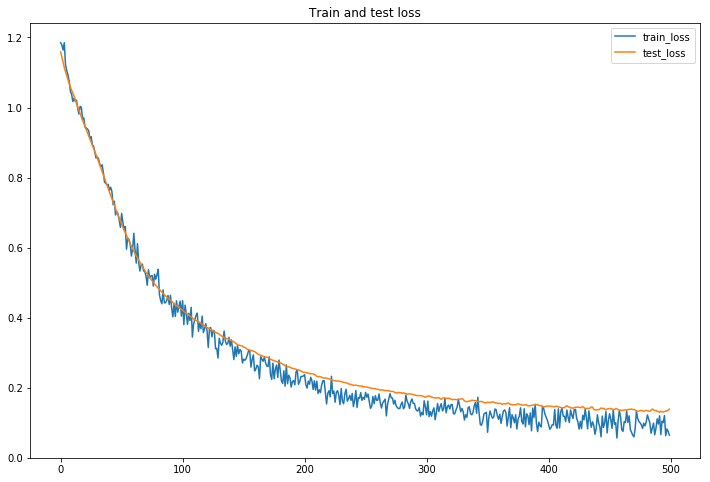

In [10]:
fig = plt.figure(figsize=(12,8))
plt.plot(train_loss, label = 'train_loss')
plt.plot(test_loss, label = 'test_loss')
plt.title("Train and test loss")
plt.legend()
plt.show()

Plotting train and test set accuracy

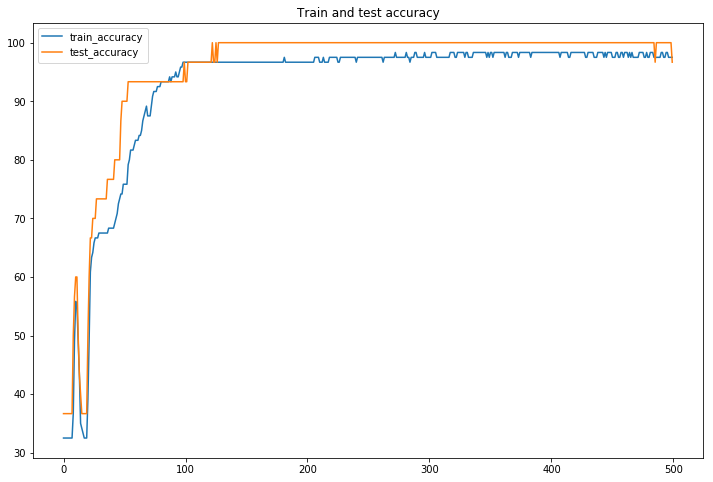

In [11]:
fig = plt.figure(figsize=(12,8))
plt.plot(train_accuracy, label = 'train_accuracy')
plt.plot(test_accuracy, label = 'test_accuracy')
plt.title("Train and test accuracy")
plt.legend()
plt.show()

Persist model to disk

In [12]:
torch.save(model.state_dict(),"./fwd_net.pth")

Load the model

In [13]:
net = IrisNet(4, 100, 50, 3)
net.load_state_dict(torch.load("./fwd_net.pth"))
net.eval()

IrisNet(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)

In [14]:
item = [[5.1,3.5,1.4,0.2]]
expected_class = 0 # Iris-Setosa

In [15]:
output = net(Variable(torch.FloatTensor(item)))

In [16]:
_, predicted_class = torch.max(output.data, 1)
print(predicted_class.numpy())
print('Predicted class:', predicted_class.numpy()[0])
print('Expected class:', expected_class)

[0]
Predicted class: 0
Expected class: 0
